In [12]:
using Gen, Plots

# Simple model

In [422]:
@gen function exam_model(students_N=200, p_leaked=0.5, normal_mean=0.5, leaked_mean=0.8, normal_std=0.1, leaked_std=0.05, p_cheater=0.3)
    is_leaked ~ bernoulli(p_leaked)
    
    scores = Vector{Float64}(undef, students_N)
    scores_raw = Vector{Float64}(undef, students_N)
    
    for i = 1:students_N
        if (({:students => i => :is_cheater} ~ bernoulli(p_cheater)) & is_leaked)
            (mu, std) = (leaked_mean, leaked_std)
        else
            (mu, std) = (normal_mean, normal_std)
        end
        scores_raw[i] = {:students => i => :score} ~ normal(mu, std)
        scores[i] = max(min(scores_raw[i], 1), 0)
    end
    scores
end;

In [423]:
function draw_histogram(trace)
    students_N = length(get_retval(trace))
    choices = get_choices(trace)
    is_leaked = choices[:is_leaked]
    scores_cheaters = []
    scores_honest = []
    for i = 1:students_N
        if choices[:students => i => :is_cheater]
            append!(scores_cheaters, choices[:students => i => :score])
        else
            append!(scores_honest, choices[:students => i => :score])
        end
    end
    
    ylim = [0, 50]
    h = histogram(vcat(scores_cheaters, scores_honest), bins=0:0.05:1, ylim=ylim, label=nothing, color=is_leaked ? "red" : "blue")
    if is_leaked | true
        h = histogram!(scores_honest, bins=0:0.05:1, ylim=ylim, label=nothing, color="blue")
    end
    h
end;

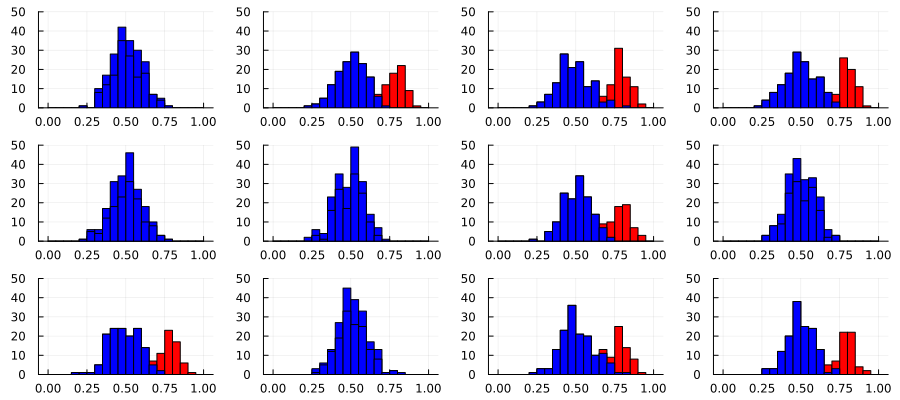

In [425]:
traces = [simulate(exam_model, ()) for _ in 1:12];
plot([draw_histogram(traces[i]) for i in 1:12]...)
plot!(size=(900,400))

## Importance resampling

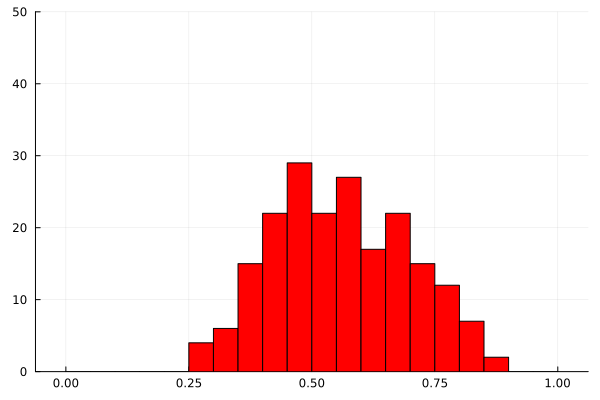

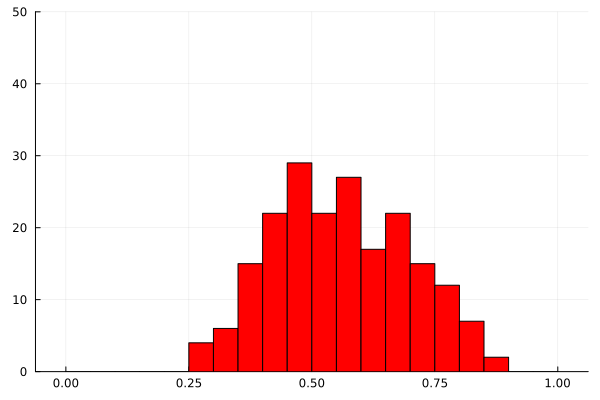

In [412]:
trace=simulate(exam_model, ())
h = histogram(trace[], bins=0:0.05:1, ylim=[0, 50], label=nothing, color=get_choices(trace)[:is_leaked] ? "red" : "blue")
display(h)

observations = Gen.choicemap()
for i = 1:1:200
    observations[:students => i => :score] = trace[][i]
end
(itrace, _) = Gen.importance_resampling(exam_model, (), observations, 1000)
h = histogram(itrace[], bins=0:0.05:1, ylim=[0, 50], label=nothing, color=get_choices(itrace)[:is_leaked] ? "red" : "blue")
display(h)

## Block resimulation

In [413]:
function block_resimulation_update(trace)
    (tr, _) = mh(trace, select(:is_leaked))
    
    for i=1:200
        (tr, _) = mh(tr, select(:students => i => :is_cheater))
    end

    tr
end;
function block_resimulation_inference(observations)
    (tr, _) = generate(exam_model, (), observations)
    for iter=1:50
        tr = block_resimulation_update(tr)
    end
    tr
end;

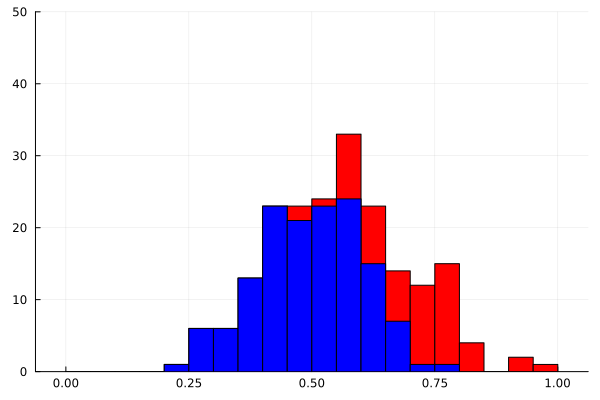

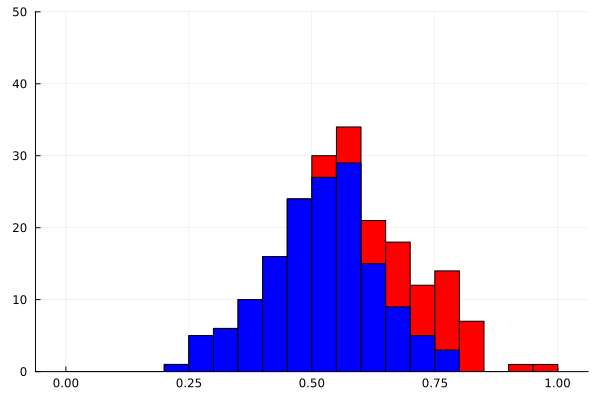

In [414]:
trace=simulate(exam_model, ())
display(draw_histogram(trace))

observations = Gen.choicemap()
for i = 1:2:200
    observations[:students => i => :score] = trace[][i]
end
itrace = block_resimulation_inference(observations)
display(draw_histogram(itrace))

## Cheater heuristic

In [406]:
p_cheater=0.3
@gen function cheaters_proposal(trace)
    # label top p_cheater scoring students as cheaters
    students_N = length(trace[])
    students_to_label = sortperm(trace[])[trunc(Int, students_N * (1-p_cheater)):students_N]
    
    for i=1:students_N
        {:students => i => :is_cheater} ~ bernoulli((i in students_to_label) ? 1.0 : 0.0)
    end
end;
@gen function cheaters_init(trace, observations)
    # label top p_cheater scoring students as cheaters
    students_N = length(trace[])
    students_to_label = sortperm(trace[])[trunc(Int, students_N * (1-p_cheater)):students_N]
    
    for i=1:students_N
        observations[:students => i => :is_cheater] = (i in students_to_label)
    end
end;
function block_resimulation_inference_with_proposal(observations)
    (tr, _) = generate(exam_model, (), observations)
    (tr, _) = mh(tr, cheaters_proposal, ())
    for iter=1:5
        tr = block_resimulation_update(tr)
    end
    tr
end;
function block_resimulation_update(trace)
    (tr, _) = mh(trace, select(:is_leaked))
    
    for i=1:200
        (tr, _) = mh(tr, select(:students => i => :is_cheater))
    end

    tr
end;
function block_resimulation_inference(observations)
    (tr, _) = generate(exam_model, (), observations)
    for iter=1:5
        tr = block_resimulation_update(tr)
    end
    tr
end;

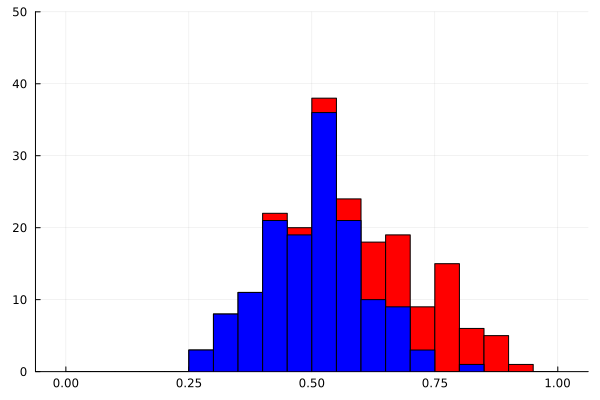

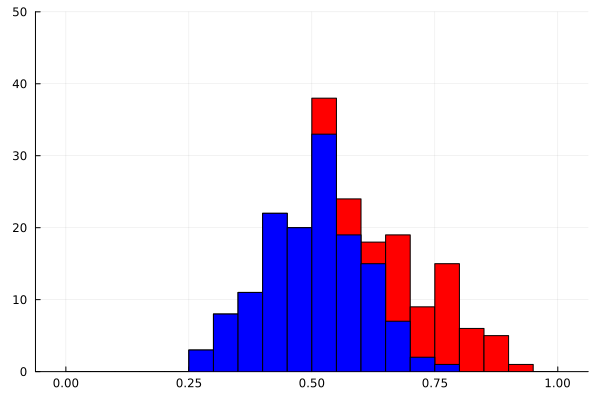

In [407]:
trace=simulate(exam_model, ())
display(draw_histogram(trace))

observations = Gen.choicemap()
for i = 1:1:200
    observations[:students => i => :score] = trace[][i]
end
cheaters_init(trace, observations)
itrace = block_resimulation_inference(observations)
display(draw_histogram(itrace))

In [408]:
N = 100

function generate_observations(trace)
    observations = Gen.choicemap()
    for i = 1:1:200
        observations[:students => i => :score] = trace[][i]
    end
    cheaters_init(trace, observations)
    return observations
end

traces= [simulate(exam_model, ()) for _=1:N]
itraces = [block_resimulation_inference(generate_observations(trace)) for trace in traces];

In [409]:
leaked = [get_choices(trace)[:is_leaked] for trace in traces]
ileaked = [get_choices(trace)[:is_leaked] for trace in itraces];

In [410]:
sum(ileaked.==leaked)

60

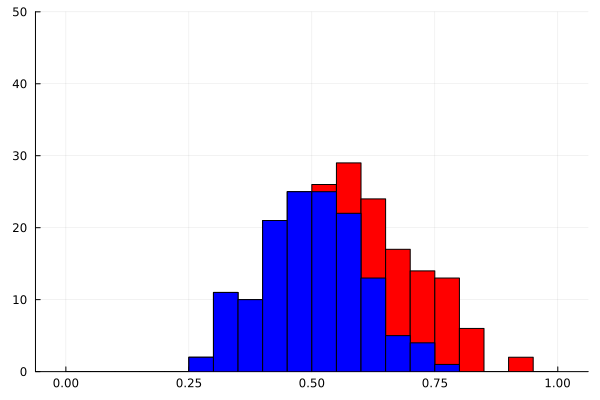

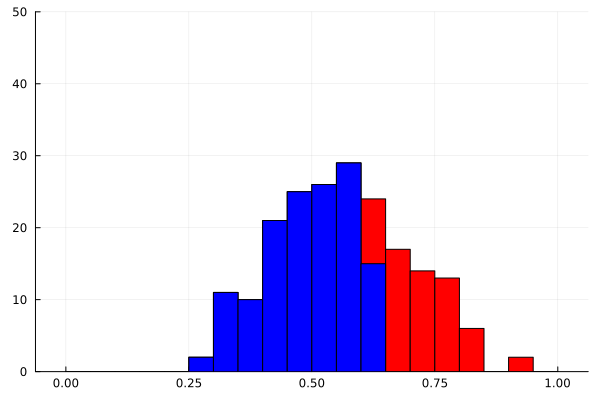

In [405]:
display(draw_histogram(traces[3]))
draw_histogram(itraces[3])

# Fancy model

In [ ]:
@gen function exam_model(students_N=50, problems_N=5, p_leaked=0.5, normal_mean=0.5, normal_std=0.1, leaked_std=0.1, p_cheater=0.3)
    is_leaked ~ bernoulli(p_leaked)
    
    test_bank = Vector{Float64}(undef, problems_N)
    for i=1:problems_N
        test_bank[i] = {:test_bank => i => :score} ~ uniform(0, 1)
    end
    
    scores = Vector{Float64}(undef, students_N)
    scores_raw = Vector{Float64}(undef, students_N)
    
    for i = 1:students_N
        cheated = {:students => i => :is_cheater} ~ bernoulli(p_cheater)
        for j = 1:problems_N
            if cheated
                (mu, std) = (test_bank[j]/problems_N, leaked_std/problems_N)
            else
                (mu, std) = (normal_mean/problems_N, leaked_std/problems_N)
            end
        end

        scores_raw[i] = {:students => i => :score} ~ normal(mu, std)
        scores[i] = max(min(scores_raw[i]/problems_N, 1), 0)
    end
    scores
end;